In [1]:
# The code was removed by Watson Studio for sharing.

# Import necesssary Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats    
import seaborn as sns
%matplotlib inline    

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.preprocessing import RobustScaler, StandardScaler, MaxAbsScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

from xgboost import XGBRegressor
import xgboost as xgb
from xgboost import plot_importance

import seaborn as sns

from IPython.display import display
import statsmodels.api as sm
import itertools
import warnings
from pylab import rcParams

# Question 4 - Can a predictive model be built for future prediction of the possibility of complaints of the specific type that you identified in response to Question 1?

## <font color="maroon">Read Data: We will focus on 'BRONX' borough as identified borough with most 'HEAT/HOT WATER' complaints from previous questions due to memory limitation.</font>

## <font color="maroon">Read Data: NYC Complaints dataset</font>

In [3]:
# Download 311 complaints from IBM cloud
client_cred.download_file(Bucket=bucket,Key='df_raw_cos_nyc.pkl',Filename='./df_raw_local.pkl')
df_nyc = pd.read_pickle('./df_raw_local.pkl')
df_nyc.head()

,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status
0,2019-12-30T13:34:17.000,45276345,HEAT/HOT WATER,10033.0,2 MAGAW PLACE,MAGAW PLACE,ADDRESS,NEW YORK,The complaint you filed is a duplicate of a co...,MANHATTAN,40.850830,-73.937283,NaN,RESIDENTIAL BUILDING,Open
1,2019-12-30T20:58:43.000,45275367,HEAT/HOT WATER,10468.0,2500 WEBB AVENUE,WEBB AVENUE,ADDRESS,BRONX,The complaint you filed is a duplicate of a co...,BRONX,40.866167,-73.904187,NaN,RESIDENTIAL BUILDING,Open
2,2019-12-30T17:18:18.000,45276885,HEAT/HOT WATER,10454.0,700 EAST 134 STREET,EAST 134 STREET,ADDRESS,BRONX,The following complaint conditions are still o...,BRONX,40.802459,-73.915132,NaN,RESIDENTIAL BUILDING,Open
3,2019-12-30T14:29:12.000,45277476,WATER LEAK,11221.0,700 GATES AVENUE,GATES AVENUE,ADDRESS,BROOKLYN,The following complaint conditions are still o...,BROOKLYN,40.687809,-73.936668,NaN,RESIDENTIAL BUILDING,Open
4,2019-12-30T16:50:51.000,45276451,UNSANITARY CONDITION,11213.0,1018 EASTERN PARKWAY,EASTERN PARKWAY,ADDRESS,BROOKLYN,The following complaint conditions are still o...,BROOKLYN,40.668992,-73.934811,NaN,RESIDENTIAL BUILDING,Open


## Filter data to contain only complaints for BRONX before Dec 31 2018 and top complaint type 'HEAT/HOT WATER' as per question 1

In [4]:
df_complaints = df_nyc[(df_nyc.created_date <= '2018-12-31') & (df_nyc.city=='BRONX') & ((df_nyc.complaint_type=='HEAT/HOT WATER') | (df_nyc.complaint_type=='HEATING'))]
df_complaints = df_complaints.dropna()
df_complaints.head()

,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status
109151,2018-12-30T11:19:41.000,41323891,HEAT/HOT WATER,10468.0,2291 DR M L KING JR BOULEVARD,DR M L KING JR BOULEVARD,ADDRESS,BRONX,The Department of Housing Preservation and Dev...,BRONX,40.860721,-73.906783,2019-01-02T02:02:57.000,RESIDENTIAL BUILDING,Closed
109155,2018-12-29T08:55:25.000,41322822,HEAT/HOT WATER,10459.0,1057 HOE AVENUE,HOE AVENUE,ADDRESS,BRONX,The Department of Housing Preservation and Dev...,BRONX,40.824309,-73.890513,2019-01-02T02:02:46.000,RESIDENTIAL BUILDING,Closed
109166,2018-12-30T14:31:50.000,41316694,HEAT/HOT WATER,10467.0,3071 PERRY AVENUE,PERRY AVENUE,ADDRESS,BRONX,The Department of Housing Preservation and Dev...,BRONX,40.872588,-73.879572,2019-01-01T09:37:20.000,RESIDENTIAL BUILDING,Closed
109171,2018-12-30T05:33:13.000,41314363,HEAT/HOT WATER,10461.0,3108 WILKINSON AVENUE,WILKINSON AVENUE,ADDRESS,BRONX,The Department of Housing Preservation and Dev...,BRONX,40.851653,-73.828635,2018-12-31T11:04:28.000,RESIDENTIAL BUILDING,Closed
109172,2018-12-30T14:46:13.000,41313337,HEAT/HOT WATER,10454.0,325 CONCORD AVENUE,CONCORD AVENUE,ADDRESS,BRONX,The Department of Housing Preservation and Dev...,BRONX,40.807012,-73.910629,2018-12-31T08:58:16.000,RESIDENTIAL BUILDING,Closed


In [5]:
# Get the shape of the dataframe
df_complaints.shape

(605941, 15)

In [6]:
# Get data types
df_complaints.dtypes

created_date               object
unique_key                  int64
complaint_type             object
incident_zip              float64
incident_address           object
street_name                object
address_type               object
city                       object
resolution_description     object
borough                    object
latitude                  float64
longitude                 float64
closed_date                object
location_type              object
status                     object
dtype: object

### Type casting for both datasets and dropping unnecessary/constant columns

In [7]:
df_complaints['created_date']= pd.to_datetime(df_complaints['created_date'])
df_complaints['closed_date']= pd.to_datetime(df_complaints['closed_date'])
df_complaints['incident_zip']= df_complaints['incident_zip'].fillna(0).astype(int)
df_complaints = df_complaints[['created_date','unique_key','incident_zip','incident_address','street_name','latitude','longitude','closed_date','location_type','status']]

In [8]:
df_complaints.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 605941 entries, 109151 to 5643999
Data columns (total 10 columns):
created_date        605941 non-null datetime64[ns]
unique_key          605941 non-null int64
incident_zip        605941 non-null int64
incident_address    605941 non-null object
street_name         605941 non-null object
latitude            605941 non-null float64
longitude           605941 non-null float64
closed_date         605941 non-null datetime64[ns]
location_type       605941 non-null object
status              605941 non-null object
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 50.9+ MB


## <font color="maroon">We will use the ARIMA time-series analysis to forecast the number of complaints in the future. To do so, we count the number of unique incidents reported historically.</font>

In [9]:
df_ts = df_complaints[['unique_key','created_date']]
df_ts.shape

(605941, 2)

### We now try to extract the month and year of reported incidents from 'created_date' column

In [10]:
df_ts = df_ts.dropna()
df_ts['date'] = df_ts['created_date'].map(lambda x: x.strftime('%Y-%m'))

In [11]:
df_ts = df_ts.drop(['created_date'], axis =1)
df_ts = df_ts.sort_values('date')
df_ts.head()

,unique_key,date
260167,15760838,2010-01
263700,15770373,2010-01
263760,15770440,2010-01
263768,15770448,2010-01
263791,15770472,2010-01


## Counting the number of reported incidents per month-year combo

In [12]:
#  count the no of complaints 
df_complaint_ts = df_ts.groupby(['date']).count()['unique_key']
df_complaint_ts = pd.DataFrame(df_complaint_ts)
df_complaint_ts = df_complaint_ts.rename(index=str, columns={"unique_key": "no_of_complaints"})

In [13]:
df_complaint_ts.head()

,no_of_complaints
date,
2010-01,13169
2010-02,7753
2010-03,5207
2010-04,2558
2010-05,1577


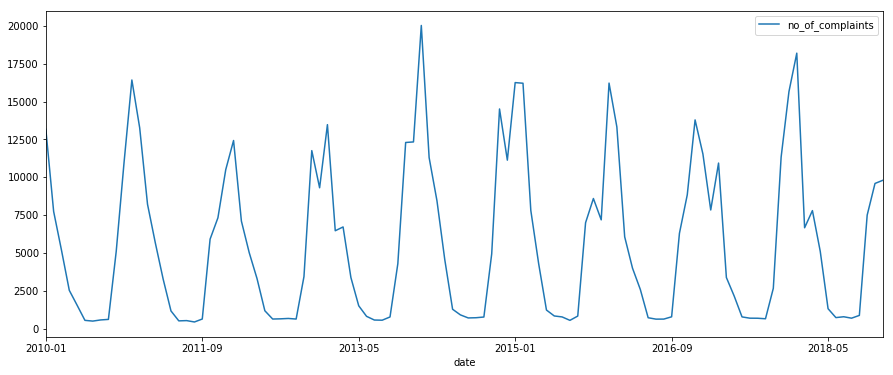

In [14]:
df_complaint_ts.plot(figsize=(15, 6))
plt.show()

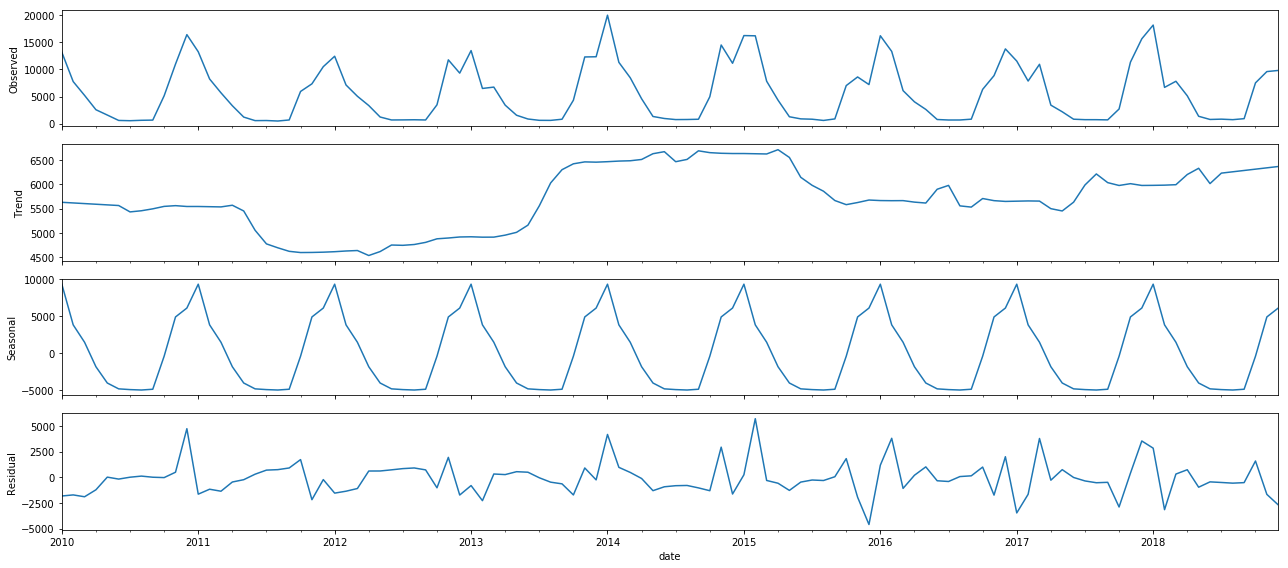

In [15]:
#trend, seasonality, and noise
df_complaint_ts = df_complaint_ts.reset_index('date')
df_complaint_ts['date'] = pd.to_datetime(df_complaint_ts['date'])
df_complaint_ts = df_complaint_ts.set_index('date')

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_complaint_ts, model='additive', extrapolate_trend='freq')
fig = decomposition.plot()
plt.show()

## By observing the above figure one can deduce that this a seasonal time series with no trend. We further examine these conclusions below:

In [16]:
# Prepare data
df_count = df_complaint_ts.copy()
df_count.reset_index(inplace=True)
df_count['date']= pd.to_datetime(df_count['date'])
df_count.head()

,date,no_of_complaints
0,2010-01-01,13169
1,2010-02-01,7753
2,2010-03-01,5207
3,2010-04-01,2558
4,2010-05-01,1577


In [17]:
df_count['year'] = [d.year for d in df_count.date]
df_count['month'] = [d.strftime('%b') for d in df_count.date]
years = df_count['year'].unique()

In [18]:
df_count.head()

,date,no_of_complaints,year,month
0,2010-01-01,13169,2010,Jan
1,2010-02-01,7753,2010,Feb
2,2010-03-01,5207,2010,Mar
3,2010-04-01,2558,2010,Apr
4,2010-05-01,1577,2010,May


In [19]:
df_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 4 columns):
date                108 non-null datetime64[ns]
no_of_complaints    108 non-null int64
year                108 non-null int64
month               108 non-null object
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.5+ KB


In [20]:
# Prep colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

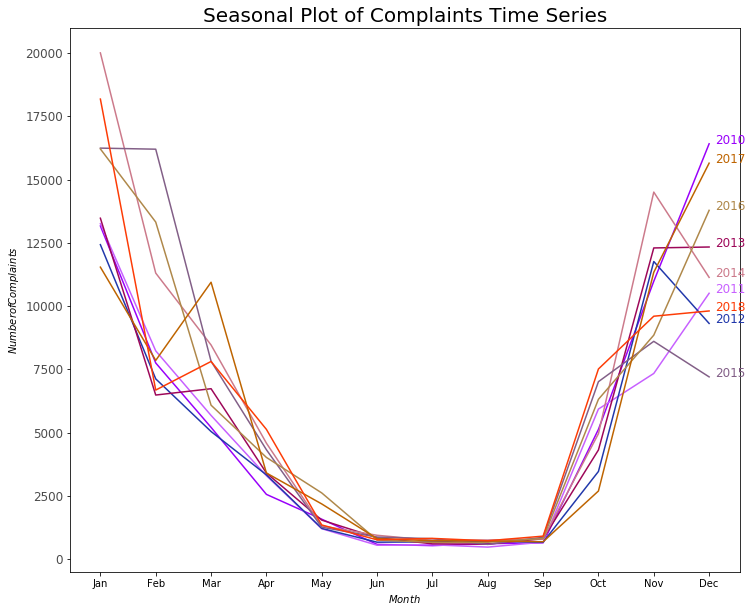

In [21]:
# Draw Plot
plt.figure(figsize=(12,10))
for i, y in enumerate(years):      
    plt.plot('month', 'no_of_complaints', data=df_count.loc[df_count.year==y, :], color=mycolors[i], label=y)
    plt.text(df_count.loc[df_count.year==y, :].shape[0]-.9, df_count.loc[df_count.year==y, 'no_of_complaints'][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(ylabel='$Number of Complaints$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Complaints Time Series", fontsize=20)
plt.show()

## It's obvious from the figure above that 'Number of Complaints' per month follow the same pattern each year

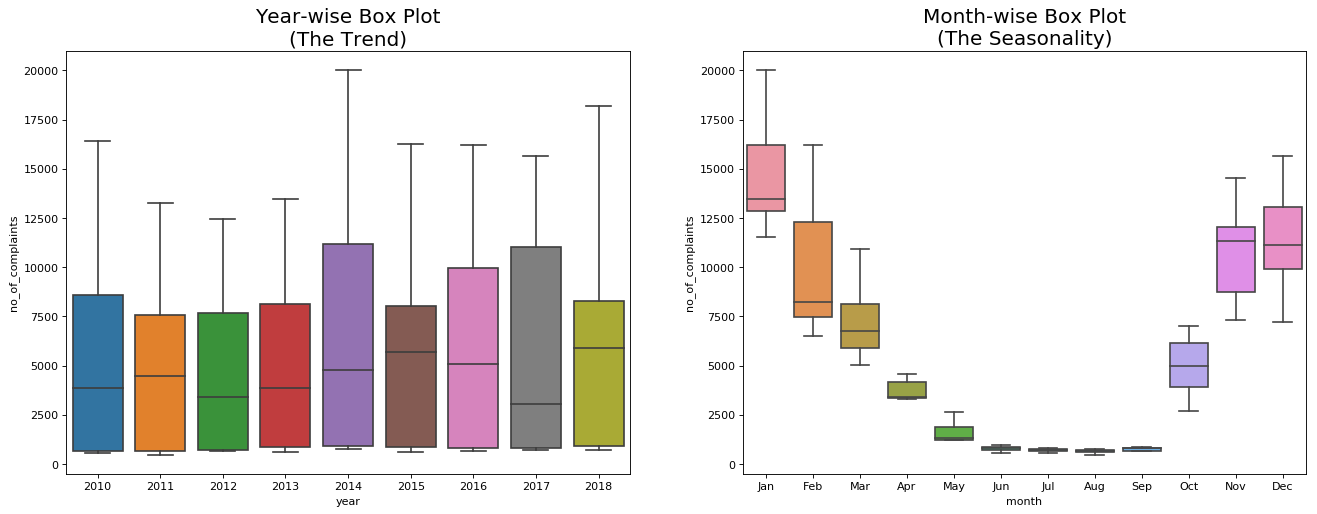

In [22]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='no_of_complaints', data=df_count, ax=axes[0])
sns.boxplot(x='month', y='no_of_complaints', data=df_count.loc[~df_count.year.isin([2010, 2018]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

## Again, seasonality zero trend charachtristic of the time series is observed above

## <font color="maroon">In order to use the ARIMA model we need to determine the parameter values p,d, and q. To do so, we study the Autocorrelation plots to determine 'd' first.</font>

In [23]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df_complaint_ts.no_of_complaints.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.634990
p-value: 0.464880


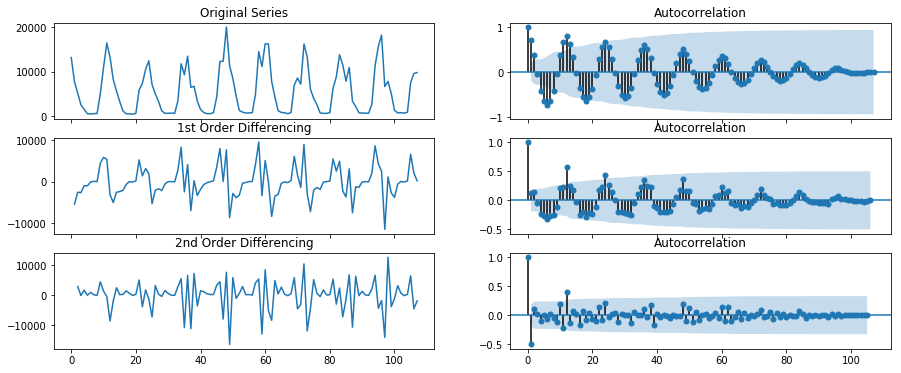

In [24]:
# Original Series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
df_acf = df_complaint_ts.copy()
df_acf.reset_index(inplace=True)

fig, axes = plt.subplots(3, 2, sharex=True, figsize=(15,6))
axes[0, 0].plot(df_acf.no_of_complaints); axes[0, 0].set_title('Original Series')
plot_acf(df_acf.no_of_complaints, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df_acf.no_of_complaints.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_acf.no_of_complaints.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df_acf.no_of_complaints.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_acf.no_of_complaints.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

## One can observe with 1st differencing we reach an acceptable level of stationary

## <font color="maroon">In order to find parameter 'p' (AR) term, we study the Partial Autocorrelation plot.</font>

In [25]:
df_complaint_ts.head()

,no_of_complaints
date,
2010-01-01,13169
2010-02-01,7753
2010-03-01,5207
2010-04-01,2558
2010-05-01,1577


/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


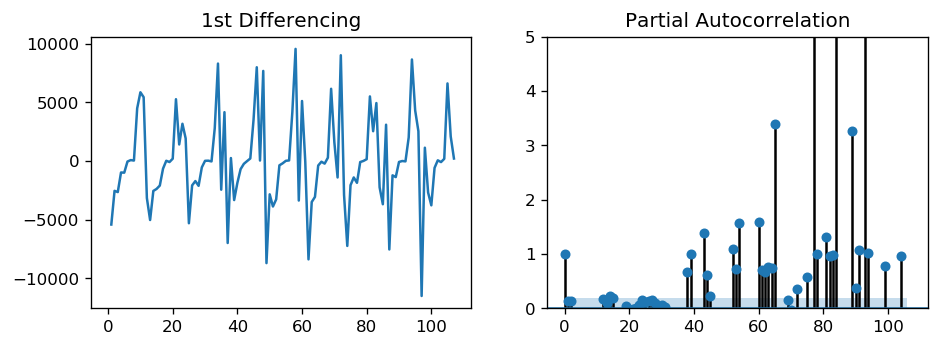

In [26]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_count.no_of_complaints.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df_count.no_of_complaints.diff().dropna(), ax=axes[1])
plt.show()

## You can observe from the PACF that none of the lags are significant since they are well below the significance limit (blue region). So we will tentatively fix the p as 0.

## <font color="maroon">In order to find parameter 'q' (MA) term, we study the Partial Autocorrelation plot.</font>

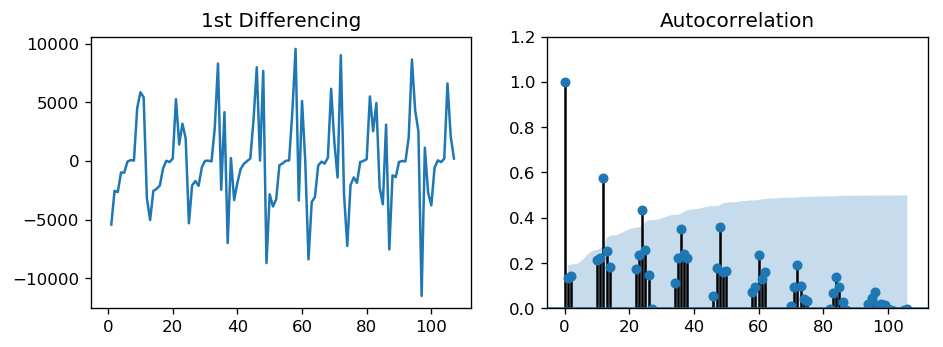

In [27]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_count.no_of_complaints.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df_count.no_of_complaints.diff().dropna(), ax=axes[1])

plt.show()

## Only 1st lag is significant so we fix parameter q as 1.

## <font color="maroon">We will validate above assumptions with a Grid search:</font>

In [28]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [29]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_complaint_ts.no_of_complaints,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2216.537737783303
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1883.4188641984827
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1749.1588591377404
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1521.6344362357318
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1766.386609845539
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1735.5188411378008
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1545.585127563362
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1519.3487429385655
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2127.882291521096
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1889.8324173293065
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1733.1102537246247
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1503.1161927447852
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1767.2512358796928
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1715.5920385876293
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1547.2537092123525
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1505.3310081126087
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2050.45702106302
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1792.773385487390

## The above grid search finds the minimum AIC value AIC:1474 which corresponds to the parameter ARIMA(0, 1, 1)x(1, 1, 1, 12). So I choose this parameter to build the ARIMA model for future prediction

In [30]:
mod = sm.tsa.statespace.SARIMAX(df_complaint_ts.no_of_complaints,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

model_fit = mod.fit()

print(model_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                   no_of_complaints   No. Observations:                  108
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -733.001
Date:                            Tue, 18 Feb 2020   AIC                           1474.002
Time:                                    02:07:36   BIC                           1483.580
Sample:                                01-01-2010   HQIC                          1477.845
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0809      0.070    -15.382      0.000      -1.219      -0.943
ar.S.L12       0.1490      0.083   

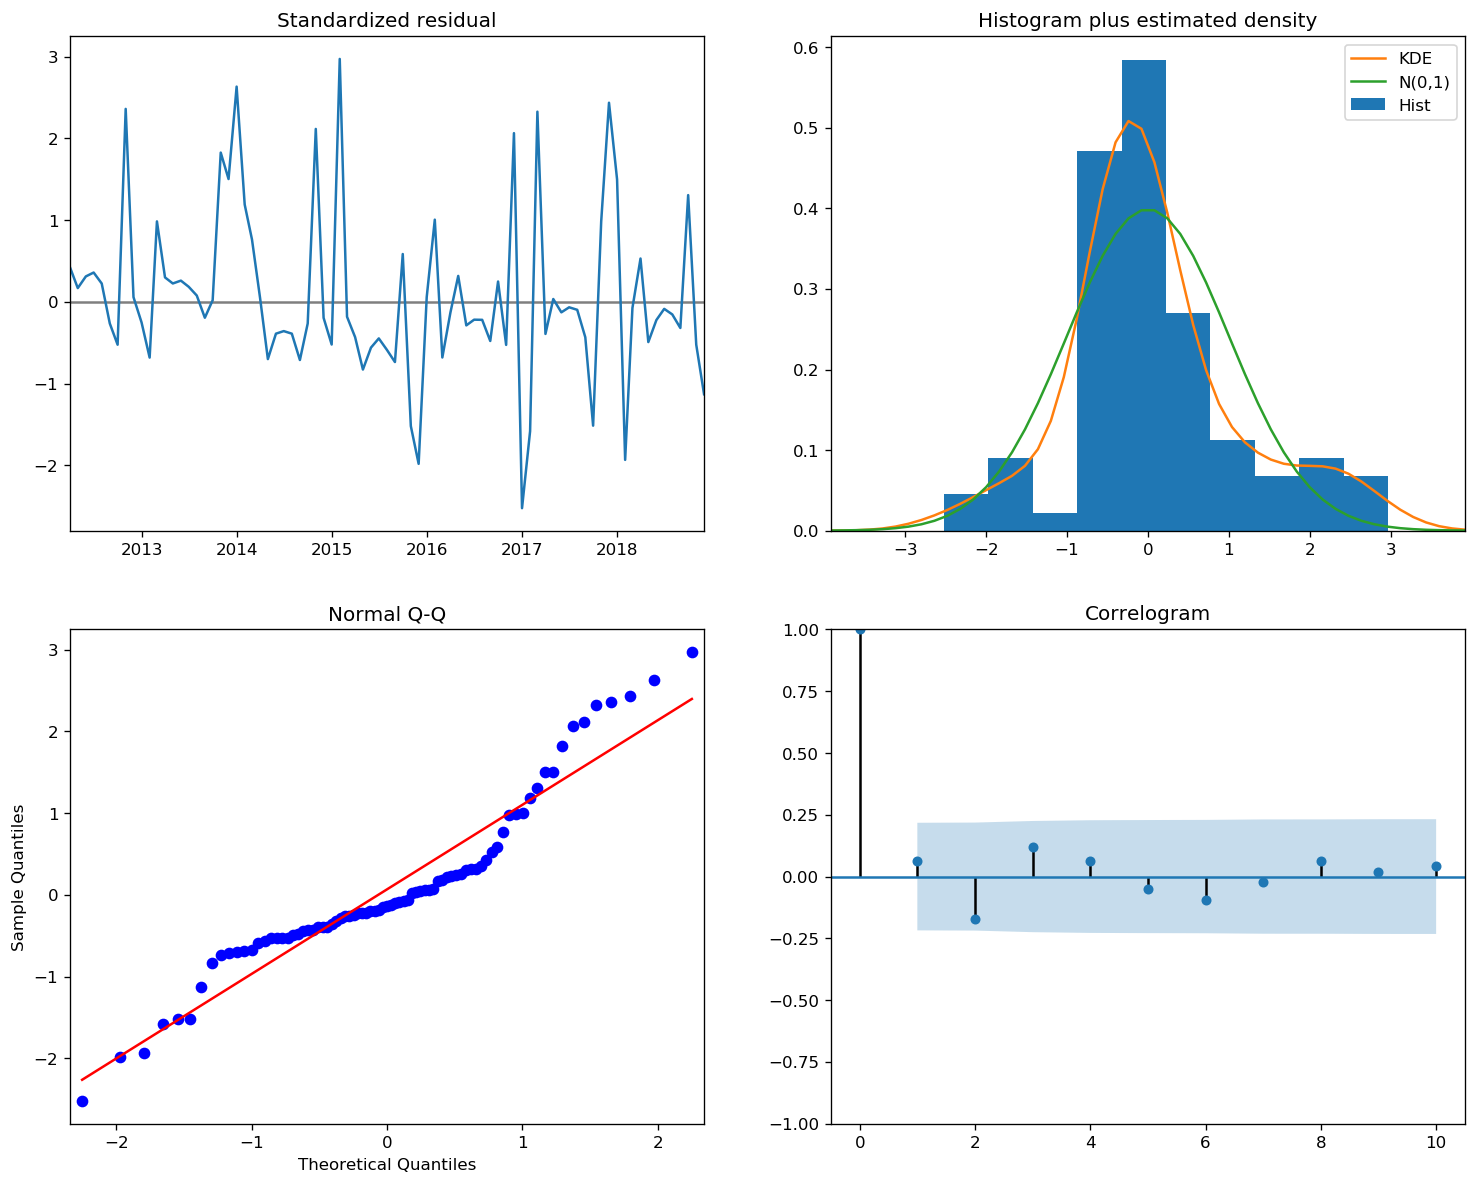

In [31]:
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

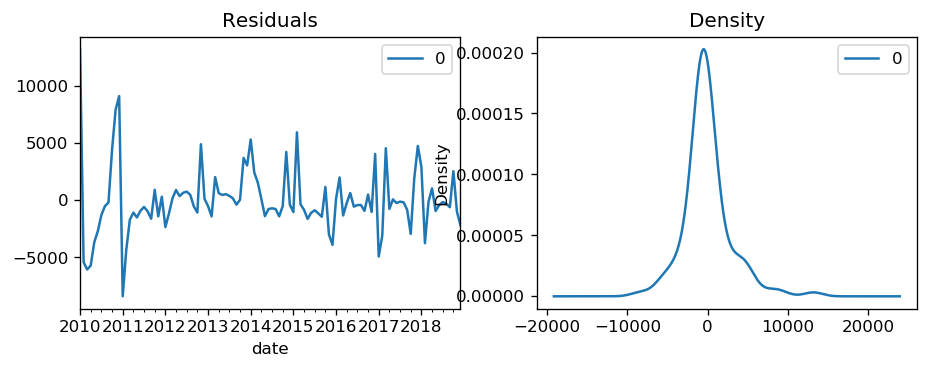

In [32]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

## <font color="maroon">Based on the above model, we generate the forecast for year 2018 to compare with our actual values:</font>

In [33]:
pred = model_fit.get_prediction(start=pd.to_datetime('2018-01'), dynamic=False)
pred_ci = pred.conf_int()

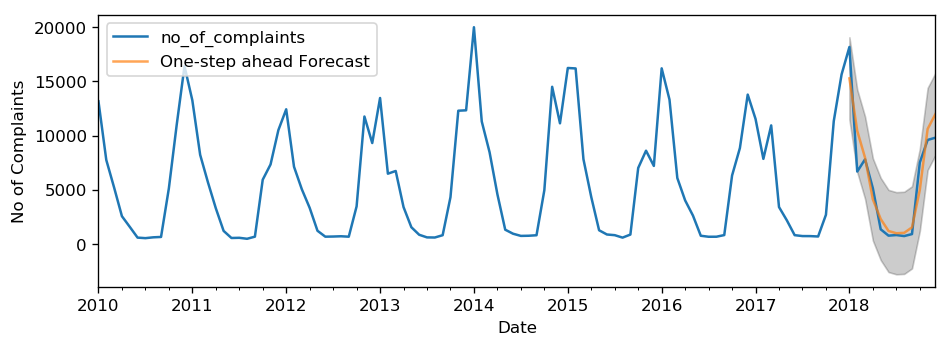

In [34]:
ax = df_complaint_ts['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('No of Complaints')
plt.legend()

plt.show()

## You can see the forecast closely follows the actual number of complaints

In [35]:
y_forecasted = pred.predicted_mean
y_forecasted = pd.DataFrame(y_forecasted)

y_truth = df_complaint_ts['2018-01':]

# Compute the mean square error
mean_absolute_error = abs((y_forecasted[0] - y_truth['no_of_complaints'] ) ** 1).mean()
print('The Mean Absolute Error of our forecasts is {}'.format(round(mean_absolute_error, 2)))

The Mean Absolute Error of our forecasts is 1335.39


## <font color="maroon">We are now ready to generate the forecasr for the next 2 years:</font>

In [36]:
# Get forecast 24 steps ahead in future
pred_uc = results.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

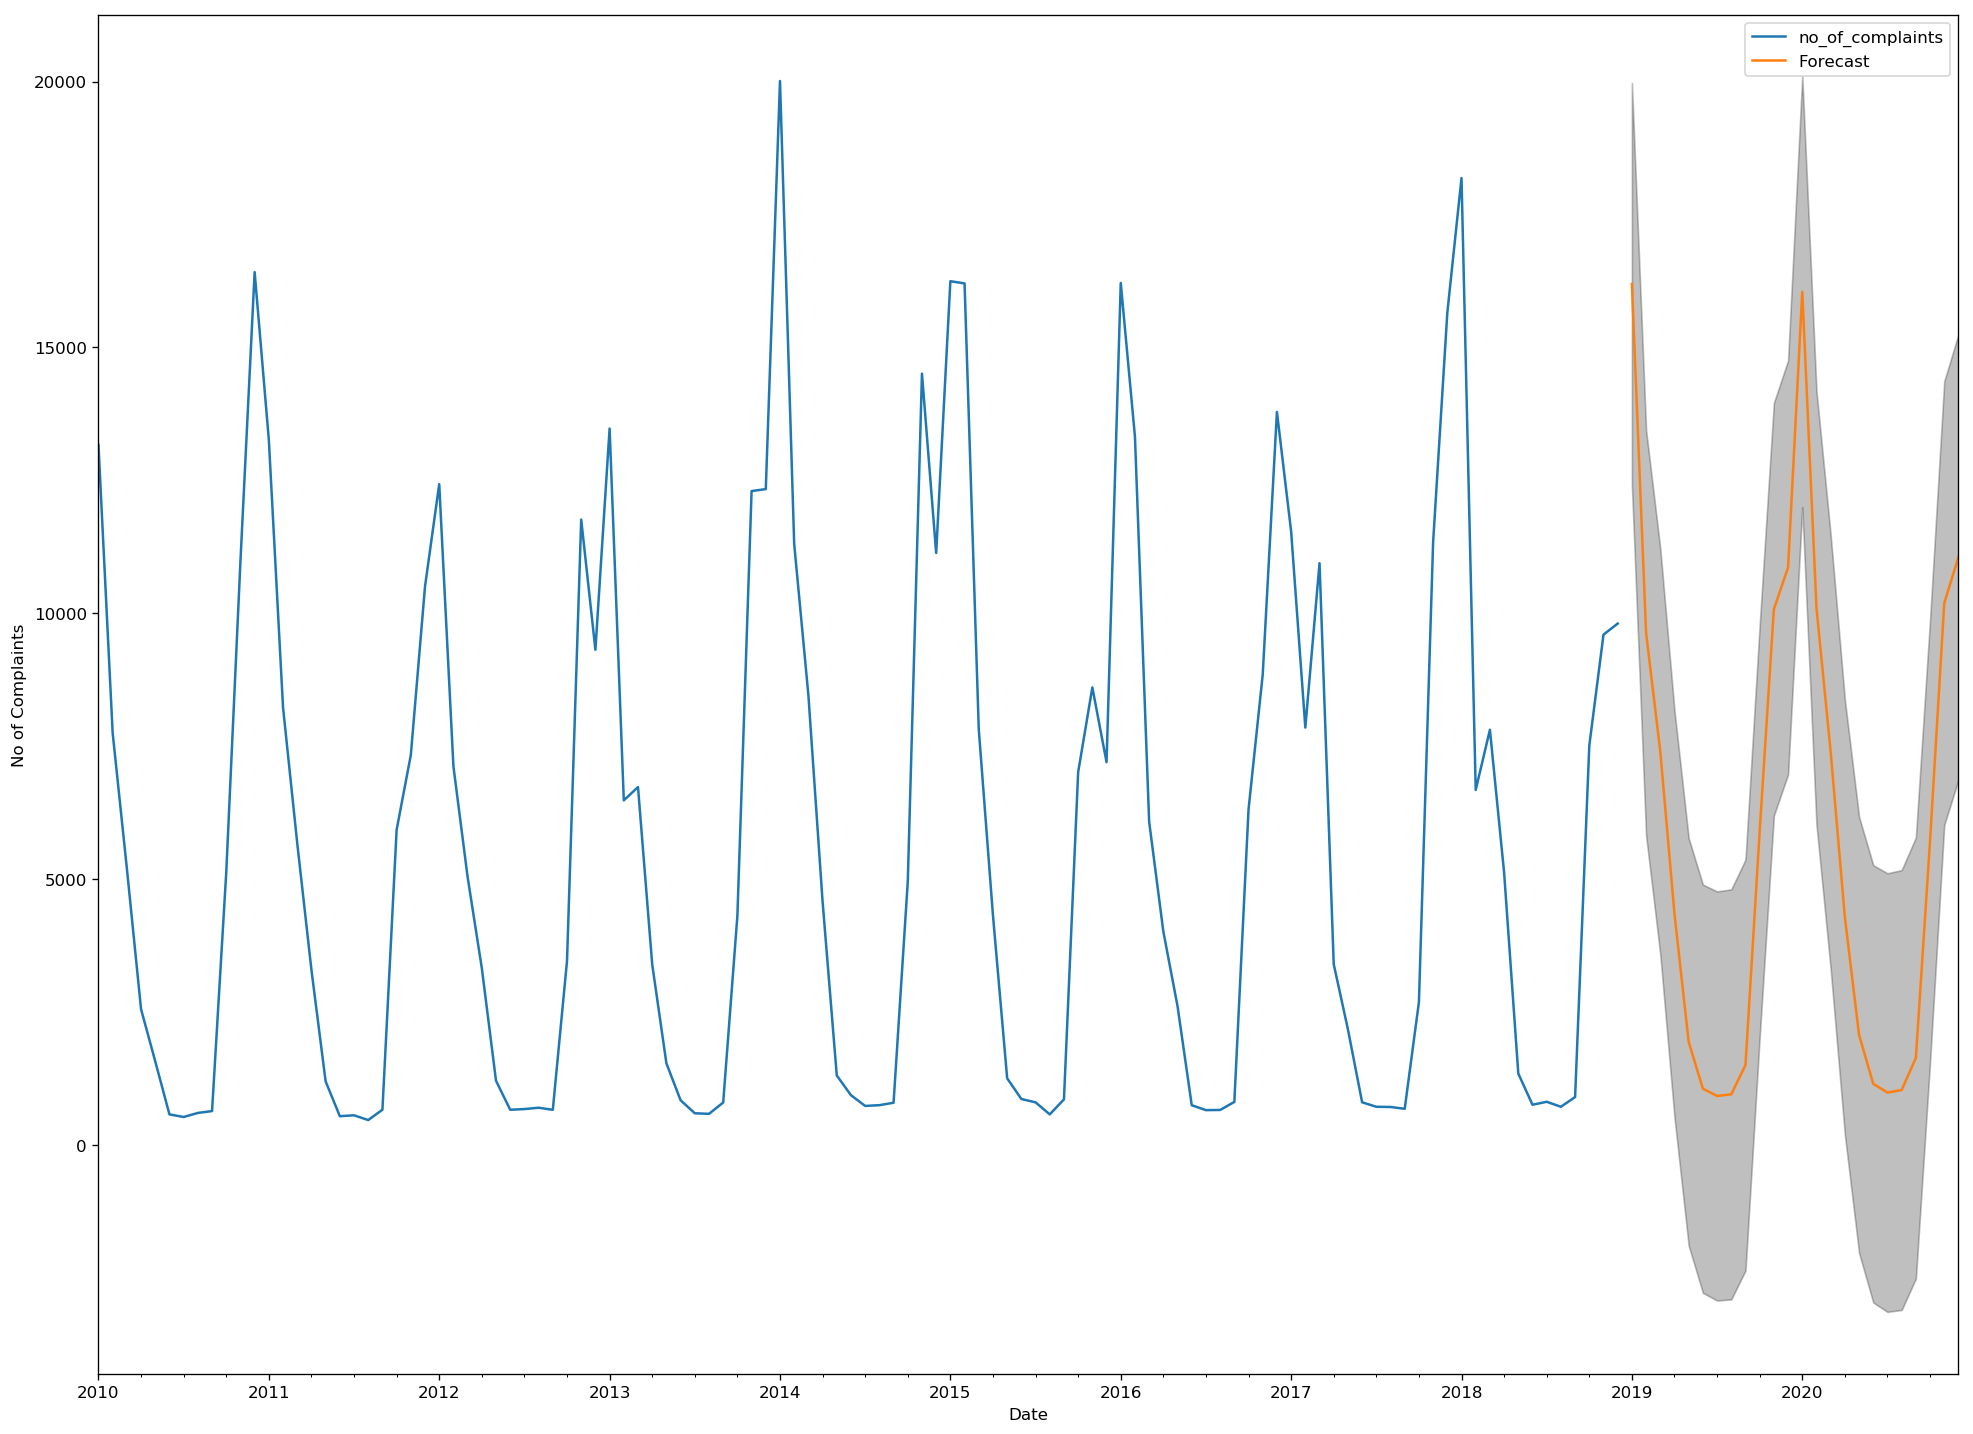

In [37]:
ax = df_complaint_ts.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('No of Complaints')

plt.legend()
plt.show()

# <font color=red> The above 'Time Series Forecasting with ARIMA' has potential to predict the future number of complaints. </font>